In [233]:
# Import libraries

import pandas as pd
import numpy as np

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

<h1>DATA COLLECTION</h1>

In [234]:
df = pd.read_csv(r'/Users/jmc/GitHub/predict-stock-prices-time-series-analysis/dataset/dataset.csv')

In [235]:
df.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

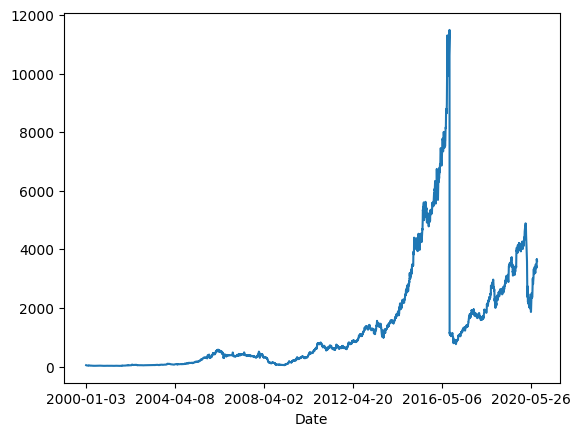

In [236]:
df['VWAP'].plot()

<h1>DATA CLEANING</h1>

In [237]:
# check for missing values
df.isna().sum()

Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2779
Deliverable Volume     446
%Deliverble            446
dtype: int64

In [238]:
# for simplicity, we'll drop NaN values
# this approach may not be the best one since a big percentage of the dataset is going to be deleted
df.dropna(inplace=True)

In [239]:
lag_features = ['High', 'Low', 'Volume', 'Turnover', 'Trades']
window1 = 3
window2 = 7

In [240]:
for feature in lag_features:
    # rolling mean
    df[feature+'_rolling_mean_3'] = df[feature].rolling(window=window1).mean()
    df[feature+'_rolling_mean_7'] = df[feature].rolling(window=window2).mean()
    
    # rolling std
    df[feature+'_rolling_std_3'] = df[feature].rolling(window=window1).std()
    df[feature+'_rolling_std_7'] = df[feature].rolling(window=window2).std()

In [241]:
df.isna().sum()

Symbol                     0
Series                     0
Prev Close                 0
Open                       0
High                       0
Low                        0
Last                       0
Close                      0
VWAP                       0
Volume                     0
Turnover                   0
Trades                     0
Deliverable Volume         0
%Deliverble                0
High_rolling_mean_3        2
High_rolling_mean_7        6
High_rolling_std_3         2
High_rolling_std_7         6
Low_rolling_mean_3         2
Low_rolling_mean_7         6
Low_rolling_std_3          2
Low_rolling_std_7          6
Volume_rolling_mean_3      2
Volume_rolling_mean_7      6
Volume_rolling_std_3       2
Volume_rolling_std_7       6
Turnover_rolling_mean_3    2
Turnover_rolling_mean_7    6
Turnover_rolling_std_3     2
Turnover_rolling_std_7     6
Trades_rolling_mean_3      2
Trades_rolling_mean_7      6
Trades_rolling_std_3       2
Trades_rolling_std_7       6
dtype: int64

In [242]:
df.dropna(inplace=True)

In [243]:
ind_features = ['High_rolling_mean_3', 'High_rolling_mean_7',
       'High_rolling_std_3', 'High_rolling_std_7', 'Low_rolling_mean_3',
       'Low_rolling_mean_7', 'Low_rolling_std_3', 'Low_rolling_std_7',
       'Volume_rolling_mean_3', 'Volume_rolling_mean_7',
       'Volume_rolling_std_3', 'Volume_rolling_std_7',
       'Turnover_rolling_mean_3', 'Turnover_rolling_mean_7',
       'Turnover_rolling_std_3', 'Turnover_rolling_std_7',
       'Trades_rolling_mean_3', 'Trades_rolling_mean_7',
       'Trades_rolling_std_3', 'Trades_rolling_std_7']

In [244]:
train_data = df[0:1800]
test_data = df[1800:]

In [245]:
# ARIMA model -> (P,d,q)
# AR - Auto Regression - PACF -> P
# I - Integrating - differencing -> d
# MA - Moving Average - ACF (Auto Corelation Factor) -> q

model = auto_arima(y=train_data['VWAP'], exogenous=train_data[ind_features], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25013.840, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25015.795, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25015.799, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25011.876, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.816 seconds


In [246]:
model.fit(train_data['VWAP'],train_data[ind_features])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [247]:
forecast = model.predict(X=test_data[ind_features],n_periods=len(test_data), exogenous=test_data[ind_features])

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [248]:
forecast

1800    2623.168086
1801    2638.845740
1802    2624.647753
1803    2597.882965
1804    2614.916992
           ...     
2280    2810.355709
2281    2890.581952
2282    2864.433394
2283    2810.619164
2284    2462.814346
Length: 485, dtype: float64

In [249]:
test_data['Forecast_ARIMA'] = list(forecast)

/var/folders/y3/46pkr_qj71g5gmxbmyj9dbh00000gn/T/ipykernel_96298/4177250722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Forecast_ARIMA'] = list(forecast)


<Axes: xlabel='Date'>

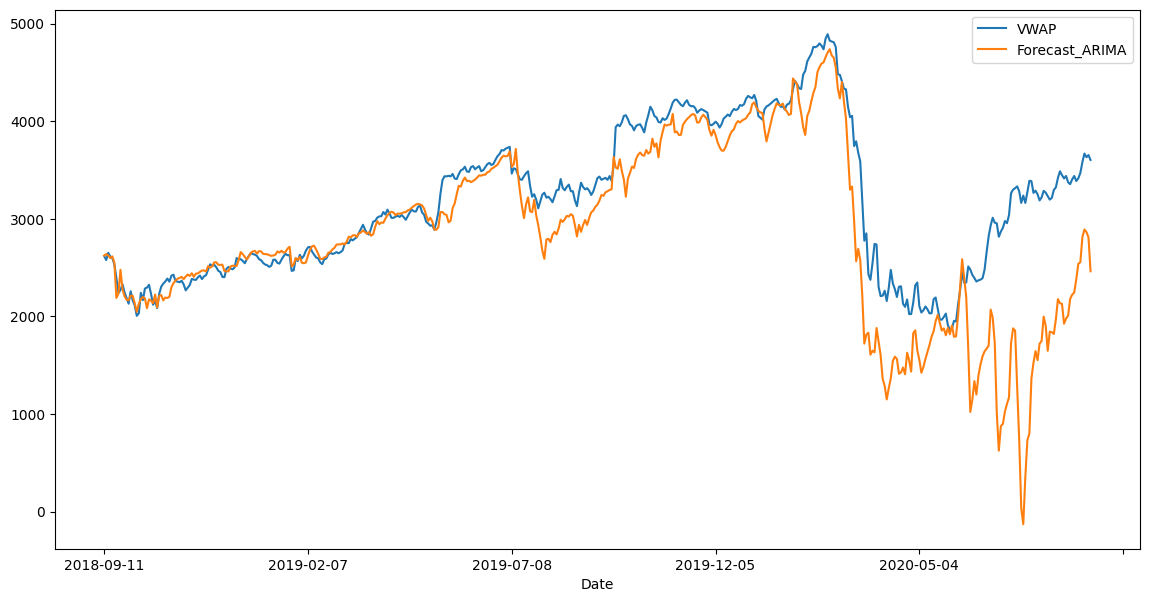

In [250]:
test_data[['VWAP','Forecast_ARIMA']].plot(figsize=(14,7))

<h1>EVALUATE MODEL</h1>

In [251]:
np.sqrt(mean_squared_error(test_data['VWAP'], test_data['Forecast_ARIMA']))

635.7520491692353

In [252]:
mean_absolute_error(test_data['VWAP'], test_data['Forecast_ARIMA'])

365.82209129940156